In [1]:
import torch
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=10, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        #x = self.encoder.maxpool(x)
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [2]:
#Para cargar una red ya entrenada
import torch
#torch.save(model,'modelo.pt')
model = torch.load('./Modelo para imagenes grandes/modelo_0.0358.pt',map_location='cpu')


torch.Size([3, 480, 640])


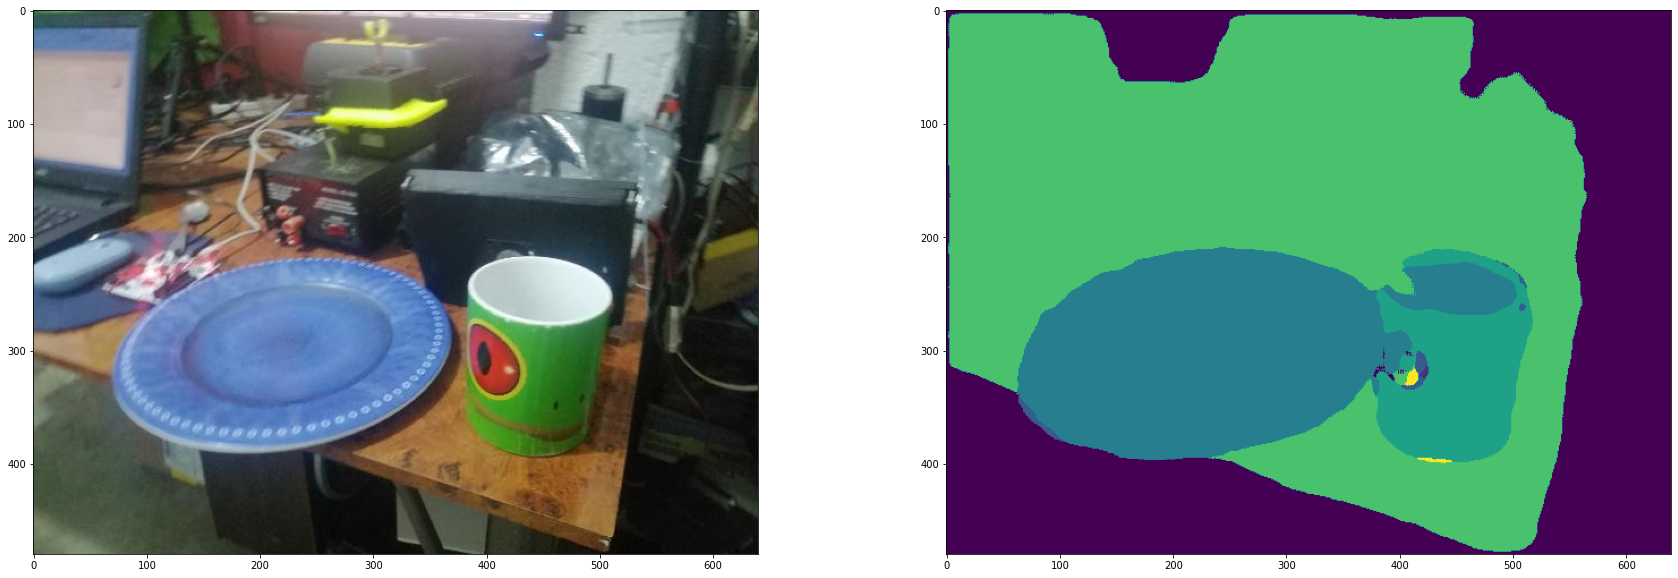

In [3]:
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./Imagenes/imagen248.jpg')
imagen=imagen.float()/255
model.eval()
with torch.no_grad():
    output = model(imagen.unsqueeze(0).to(device))[0]
    mascara_pred = torch.argmax(output, axis=0)

np.save('./mascara',mascara_pred.numpy())
print(imagen.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(imagen.squeeze(0).permute(1,2,0))
ax2.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

210900.5
289


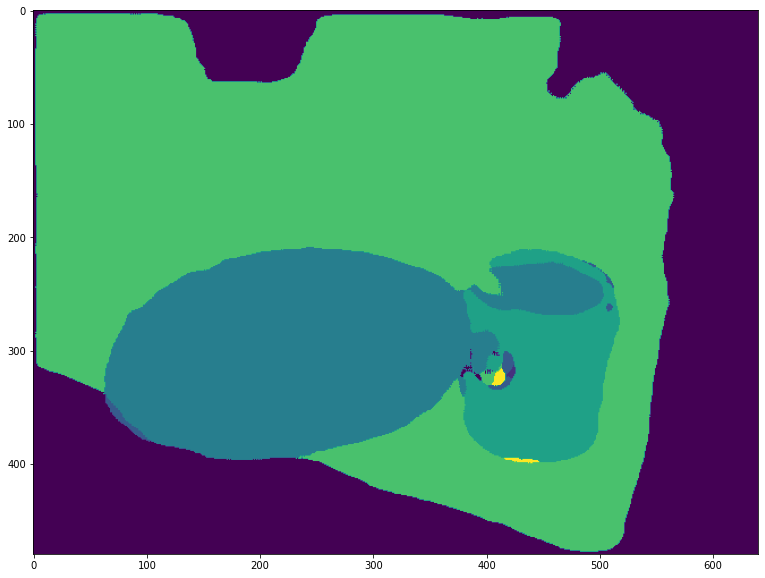

In [4]:
import cv2

output = model(imagen.unsqueeze(0))[0]
mascara = torch.argmax(output,axis=0).numpy().astype(np.uint8)

contornos,_=cv2.findContours(mascara,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mascara,contornos,-1,(2,2,2),1)

areaMayor=0
ContornoMayor=None
for cnt in contornos:
    area = cv2.contourArea(cnt)
    if area>areaMayor:
        areaMayor=area
        contornoMayor=cnt
                    
print(areaMayor)
   
if areaMayor>100:
    m = cv2.moments(contornoMayor)
    if m['m00'] != 0:
        cx = int(m['m10']/m['m00'])
        cy = int(m['m01']/m['m00'])
        cv2.drawContours(mascara, [contornoMayor], -1, (2,2,2), 2)
        cv2.circle(mascara, (cx, cy), 3, 2, 1)
    print(cx)

mascara_pred=np.load('./mascara.npy')
mascara_pred=torch.tensor(mascara_pred)
fig, (ax1) = plt.subplots(1, 1, figsize=(30,10))
ax1.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

In [1]:
from confRed import *
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np


In [2]:

import cv2

#torch.save(model,'modelo.pt')
model = torch.load('./Modelo para imagenes pequeñas/modelo.pt',map_location='cpu')
#model = torch.load('./Modelo para imagenes pequeñas/modelo_0.0326.pt',map_location='cpu')



device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./ImagenesPequeñas/imagen18.jpg')
#imagen= np.load('./Imagenes/imagen181.npy')
imagen=imagen.float()/255


/home/despacho/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/despacho/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/despacho/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the

In [6]:
output = model(imagen.unsqueeze(0))[0]
mascara = torch.argmax(output,axis=0)
print(mascara)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 5, 5, 0],
        [0, 0, 0,  ..., 5, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [16]:
output = model(imagen.unsqueeze(0))[0]
mascara = torch.argmax(output,axis=0).numpy().astype(np.uint8)

for i in mascara:
    for j in mascara:
        print(mascara[i][j])